# Supervised Representation Learning 

In this tutorial we show how to perform supervised representation learning using a VGGish Network.

In [1]:
%xmode minimal

import os
import json

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers, models

import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

# Turn off logging for TF
import logging
tf.get_logger().setLevel(logging.ERROR)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Exception reporting mode: Minimal


2024-05-19 17:31:44.279504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 17:31:45.037781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import dpmhm
# dpmhm.datasets.get_dataset_list()

from dpmhm.datasets import preprocessing, feature, utils

In [3]:
outdir = Path('/home/han/tmp/vggish')
os.makedirs(outdir, exist_ok=True)

## Load the CWRU dataset

We use the CWRU dataset for this tutorial. Suppose it has been correctly installed. We load it using the method `tfds.load()`.

In [4]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name,
    with_info=True,
)

ds0 = ds_all['train']

ds0.element_spec

2024-05-19 17:19:28.965206: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-19 17:19:28.965228: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: Pluto
2024-05-19 17:19:28.965233: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: Pluto
2024-05-19 17:19:28.965302: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.78.0
2024-05-19 17:19:28.965319: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.78.0
2024-05-19 17:19:28.965323: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.78.0


{'metadata': {'Dataset': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

### Preprocessing pipeline

Next let's define a preprocessing pipeline consisting of
- selecting data files that contain simultaneously all 3 channels & label ramification
- feature extraction: compute the spectrogram
- sliding window view that yields patches of fixed dimension

In [5]:
from dpmhm.datasets import transformer, feature

compactor = transformer.DatasetCompactor(ds0,
                                         channels=['DE', 'FE', 'BA'],
                                         keys=['FaultLocation', 'FaultComponent', 'FaultSize'],
                                         resampling_rate=12000)

# Feature extractor
# Spectrogram is computed on a time window of 0.025 second every 0.0125 second, then converted to decibel scale.
_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram',
#                                                 n_mfcc=256,
                                                time_window=0.025, hop_step=0.0125, n_fft=512,
                                                normalize=False, to_db=True)[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

# A window of width w correspond to w*0.0125 seconds
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))
# window = transformer.WindowSlider(extractor.dataset, window_size=(256, 80), hop_size=40)  # 1s, full bandwidth
# window = transformer.WindowSlider(extractor.dataset, window_size=64, hop_size=32)

compactor.dataset.element_spec

{'label': TensorSpec(shape=(), dtype=tf.string, name=None),
 'sampling_rate': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'signal': TensorSpec(shape=(3, None), dtype=tf.float32, name=None)}

Print the dictionary of all labels

In [6]:
labels = list(compactor.full_label_dict.keys())  # need the whole list of labels
print("Number of classes:", len(labels))

compactor.full_label_dict
# compactor.label_dict

2024-05-19 17:19:30.417980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-19 17:19:30.670483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number of classes: 29


2024-05-19 17:19:30.927873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'f6ab3549af9ee45a': ['DriveEnd', 'Ball', '0.014'],
 '2533c59036dfe8c8': ['FanEnd', 'InnerRace', '0.007'],
 'b0a92d9d7379d8ce': ['DriveEnd', 'InnerRace', '0.007'],
 'dc8bcb86c369e78b': ['FanEnd', 'InnerRace', '0.021'],
 'd766ecd2592ce5ec': ['DriveEnd', 'Ball', '0.021'],
 '8af14bb8ad669337': ['FanEnd', 'OuterRace12', '0.007'],
 '55503c950ed81973': ['FanEnd', 'Ball', '0.014'],
 'd45bbeb3b8a72222': ['DriveEnd', 'OuterRace6', '0.007'],
 '44bf66c5d8cd30e6': ['DriveEnd', 'OuterRace12', '0.021'],
 'd8957867a1fc0519': ['DriveEnd', 'OuterRace3', '0.007'],
 '9c54396620a4b6a3': ['DriveEnd', 'OuterRace6', '0.021'],
 '8b9e80c02e1fca5b': ['FanEnd', 'OuterRace6', '0.007'],
 'a760eef52ceaa6f9': ['FanEnd', 'OuterRace3', '0.021'],
 '35929ddfb4abb54d': ['DriveEnd', 'OuterRace12', '0.007'],
 'e27e22f1f5037a20': ['DriveEnd', 'InnerRace', '0.014'],
 '5feef6a8996ff730': ['FanEnd', 'OuterRace6', '0.014'],
 'd6de9a13f405da29': ['FanEnd', 'Ball', '0.007'],
 '6c2ba36f712d55e4': ['DriveEnd', 'OuterRace6', '0.014'

Here's how the spectrogram patches look like:

2024-05-19 17:19:31.470930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-19 17:19:31.827502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


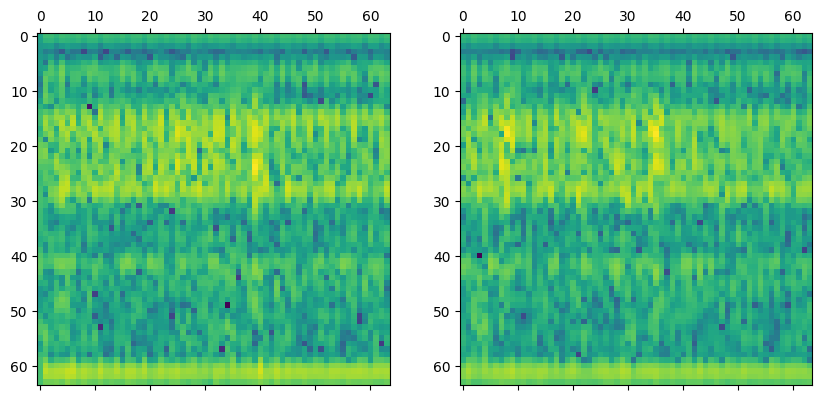

In [7]:
eles = list(window.dataset.take(10).as_numpy_iterator())

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].matshow(eles[0]['feature'][0])
axes[1].matshow(eles[9]['feature'][0])

As the last step of preprocessing, apply a preprocessing mapping to transform the dataset to the tuple `(feature, label)` compatible for supervised learning, with the field `feature` in the channel-last format. Finally the preprocessed dataset can be exported to disk for reuse.

In [9]:
preproc = preprocessing.get_mapping_supervised(labels)

with open(outdir/'labels.json', 'w') as fp:
    json.dump(compactor.full_label_dict,fp)
    
ds_window = window.dataset.map(preproc, num_parallel_calls=tf.data.AUTOTUNE)

eles = list(ds_window.take(10).as_numpy_iterator())
input_shape = eles[0][0].shape

# Ensure the input shape
# An issue in Keras 3:
# https://github.com/tensorflow/tensorflow/issues/64177
ds_window = ds_window.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)

ds_window.save(str(outdir/'cwru'))

2024-05-19 17:19:49.685605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-19 17:19:53.005244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Load the preprocessed dataset

The preprocessed dataset can be loaded from the disk.

In [6]:
ds_window = tf.data.Dataset.load(str(outdir/'cwru'))

with open(outdir/'labels.json', 'r') as fp:
    labels = list(json.load(fp).keys())

# # Ensure the input shape
# ds_window = ds_window.map(lambda x,y: (tf.ensure_shape(x, input_shape), y), num_parallel_calls=tf.data.AUTOTUNE)

2024-05-19 17:32:15.839462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
print(f"Total number of elements: {ds_window.cardinality()}")
ds_window.element_spec

Total number of elements: 16296


(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Train a VGGish network

Note that the Keras preprocessing model included an outlier class (of label `0`) in the final dataset, we must accordingly increase the number of classes by 1.

In [9]:
eles = list(ds_window.take(10).as_numpy_iterator())
input_shape = eles[0][0].shape

n_classes = len(labels)+1  # must add one for the outlier class, Keras uses zero-based class labels.
print(f"Number of class: {n_classes}")

splits = {'train':0.7, 'val':0.2, 'test':0.1}
ds_split = utils.split_dataset(ds_window, splits, ds_size=int(ds_window.cardinality()))

Number of class: 30


In [10]:
# Create the training/validation/test set with mini-batches
batch_size = 32

ds_size = 20000  # use a large number
ds_train = ds_split['train'].shuffle(ds_size, reshuffle_each_iteration=True).cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_split['val'].batch(batch_size)
ds_test = ds_split['test'].batch(1)

ds_train.element_spec

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Implementation 1: Keras pretrained model with transfer learning

Keras comes with a VGG16 model pretrained on Imagenet that can be reused for feature embedding. We load and freeze the pretrained weights and perform transfer learning only on final classification layers.

In [11]:
from keras.applications import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape, classes=n_classes)

base_model.trainable = False

In [12]:
x = layers.Input(input_shape)

adapt_model = models.Sequential([
    layers.Flatten(name="flatten"),
    layers.Dense(4096, activation="relu", name="fc1"),
    layers.Dense(4096, activation="relu", name="fc2"),
    layers.Dense(n_classes, activation=None, name="predictions")
])

y = adapt_model(base_model(x))

# Equivalent:
# x = base_model(x)
# x = layers.Flatten(name="flatten")(x)
# x = layers.Dense(4096, activation="relu", name="fc1")(x)
# x = layers.Dense(4096, activation="relu", name="fc2")(x)
# y = layers.Dense(n_classes, activation=None, name="predictions")(x)

In [13]:
model = models.Model(x, y)

from_logits = 'softmax' not in str(model.layers[-1].get_layer('predictions').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [14]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 127s 350ms/step - accuracy: 0.5214 - loss: 3.7552 - val_accuracy: 0.9101 - val_loss: 0.2769
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 123s 346ms/step - accuracy: 0.9255 - loss: 0.2217 - val_accuracy: 0.9515 - val_loss: 0.1628
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 123s 345ms/step - accuracy: 0.9483 - loss: 0.1590 - val_accuracy: 0.9727 - val_loss: 0.0853
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 122s 341ms/step - accuracy: 0.9588 - loss: 0.1418 - val_accuracy: 0.9693 - val_loss: 0.0822
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 122s 342ms/step - accuracy: 0.9665 - loss: 0.1127 - val_accuracy: 0.9834 - val_loss: 0.0552


In [15]:
model.evaluate(ds_test)

1630/1630 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9777 - loss: 0.0619


[0.05482785403728485, 0.9822086095809937]

#### Fine tuning

After training, we can perform several steps of fine tuning with a small learning rate.

In [18]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [19]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=2,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)

Epoch 1/2
357/357 ━━━━━━━━━━━━━━━━━━━━ 341s 946ms/step - accuracy: 0.9744 - loss: 0.0925 - val_accuracy: 0.9957 - val_loss: 0.0106
Epoch 2/2
357/357 ━━━━━━━━━━━━━━━━━━━━ 335s 940ms/step - accuracy: 0.9939 - loss: 0.0201 - val_accuracy: 0.9932 - val_loss: 0.0199


In [20]:
model.evaluate(ds_test)

1630/1630 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9941 - loss: 0.0338


[0.027062658220529556, 0.9926380515098572]

In [17]:
model.save(str(outdir / 'vggish_model_transfer.keras'))

### Implementation 2: from scratch

We provide an implementation of the VGGish network. Unlike the Keras implementation, weights are not pretrained here so the training may be longer. 

In [21]:
from dpmhm.models.sl import vggish

In [22]:
config = vggish.Config(input_shape=input_shape, n_embedding=128, n_classes=n_classes, padding='same', activation='relu',)
model = vggish.VGG11(config)

print(config)

model.summary()

# l=model.get_layer('classifier')

Config(input_shape=(64, 64, 3), batch_size=256, epochs=100, training_steps=1000, n_classes=30, n_embedding=128, kernel_size=(3, 3), activation='relu', activation_classifier=None, padding='same', pool_size=(2, 2), strides=(2, 2))


Model: "VGGish-A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_2 (Conv2D)                │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_1 (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1_2 (Dense)                   │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,922,782 (133.22 MB)

 Trainable params: 34,922,782 (133.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from_logits = 'softmax' not in str(model.get_layer('classifier').activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
    metrics=['accuracy'],
)

In [25]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 192s 537ms/step - accuracy: 0.9153 - loss: 0.3731 - val_accuracy: 0.9368 - val_loss: 0.2900
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 190s 532ms/step - accuracy: 0.9170 - loss: 0.4103 - val_accuracy: 0.9810 - val_loss: 0.0912
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 192s 537ms/step - accuracy: 0.9695 - loss: 0.1564 - val_accuracy: 0.8846 - val_loss: 0.4811
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 188s 528ms/step - accuracy: 0.8788 - loss: 0.5810 - val_accuracy: 0.9712 - val_loss: 0.1216
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 188s 526ms/step - accuracy: 0.9617 - loss: 0.1724 - val_accuracy: 0.9537 - val_loss: 0.2963
Epoch 5: early stopping


In [26]:
model.evaluate(ds_test)

1630/1630 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9563 - loss: 0.3218


[0.26855865120887756, 0.9527607560157776]

In [27]:
model.save(str(outdir / 'vggish_model_scratch.keras'))

# EOF

In [ ]:
xs = np.asarray([ele[0] for ele in eles])
ys = np.asarray([ele[1] for ele in eles])

history = model.fit(
    x=xs,
    y=ys,
    epochs=1
)
